__Tenant Churn Model to predict the tenant turnover with the past data__

- By: [Kathirvel Kumararaja]()

# Problem Statement

![title](../assets/churn.jpeg)  


Tenant Churn or Tenant turnover is one of the challenges if you are managing multiple properties with diversified tenants. Modeling tenant churn is a classical application of data science. To put in a simple language a churn model is a classification model that given a set of predictors, or input variables, predicts the status of a tenant. Our churn model will predict, if a tenant rents a unit, the probability that tenant is a churned or a non churned tenant. Armed with this knowledge a property manager can better understand how the tenant mix will change over time and which units are likely to become available soon. This will enable managers to proactively target the high churn candidates and provide incentives for them to extend their contract. In addition, the model can highlight which units likely will need to be filled in the future, so that the vacancy period of a unit can be reduced. The __data we are using for this modeling is anonymized with all the personal info removed__ to protect the privacy of the tenants. 

- This is a classsification model.

- We will be evaluating our model based on __Accuracy.__ 

# Executive Summary

Various indusrties define Churn slightly differently. It also varies by each organization or product. Generally, the customers who stop using a product or service for a given period of time are referred to as churners. As a result, churn is one of the most important elements in the Key Performance Indicator (KPI) of a product or service. A full customer lifecycle analysis requires taking a look at retention rates in order to better understand the health of the business or product. 

Our model attempted to find churn rate for Residential tenants. To address the challenge of finding the comprehensive data for our modeling, our first strategy is to finalize a good source of data which will help us in understanding the tenant Move-In Move-out behavior. While most of us think that Residential and Commercial rentals have mostly to do with capital investment the actual profit that a typical Property Manager makes is just between 8% to 9%. 


Another challenge we were having was getting enough data. Our target was close to 2000 records from a Property Management System. After getting approval from my client I have exported the Resident History information. The information was kept in a MS SQL Server database. I developed a report using Crystal report to filter the required data.   

After extracting the data next decision we had to make was what column or columns needs to be my X. Majority of the columns were date based. Initially I was inclined to use all the date columns in a Time series model. But after reviewing business objective I deicided to use classification model that will determine whether a tenant is churned or current. 

EDA helped me set up a preprocessing plan for our model. For preprocessing, I had created a function that removed spaces and thousand separators. For modeling I have five different models. 
 
Machines had no problem understanding the data, after I engineered features that reflected the business needs.

__Data Dictionary__

|Tenant Traffic|Type|Dataset|Description|
|---|---|---|---|
|Unit|float|Tenant_traffic|This field represents Unique identification of rental units| 
|Tcode|int|Tenant_traffic|Represent the read/write score| 
|Rent|int|Tenant_traffic|This field represent the Rent of the Unit| 
|Base|int|Tenant_traffic|This field represent the Mean Late fee calculation condition| 
|Criteria|float|Tenant_traffic|This field represent the % of participation| 
|Grace_Period|int|Tenant_traffic|Represent the read/write score| 
|Legal_Rent|int|Tenant_traffic|This field represent the Legal Rent a Tenant can collect| 
|Deposit|int|Tenant_traffic|This field represent the Deposit held by the landlord| 
|From|float|Tenant_traffic|This field represent the Lease Starting Month| 
|To|int|Tenant_traffic|Represent the the Lease Ending Month| 
|Move_In|int|Tenant_traffic|This field represent the Date Tenant Moved In| 
|Move_Out|int|Tenant_traffic|This field represent the Date Tenant Moved Out| 
|Months_Occupied|int|Tenant_traffic|This field represent the number of months tenant| 
|Last_Renewal|int|Tenant_traffic|This field represent the Last Renewal date| 
|Tenant_Status|float|Tenant_traffic|This field represent the status Current or Pat| 
|Roommates-Y|int|Tenant_traffic|Represent the read/write score| 
|ACH-Y|int|Tenant_traffic|This field signed up for ACH payments| 

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import time
import requests

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, Lasso, ElasticNetCV
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification

#importing stats model for GLM
import statsmodels.api as sm
from sklearn.datasets import make_regression, make_multilabel_classification

%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense
import warnings
warnings.filterwarnings('ignore')

# For reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

#import pickles
import pickle

/Users/kraja/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/Users/kraja/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)
Using TensorFlow backend.


In [2]:
#Read the data for resident info
df = pd.read_csv("../datasets/TenantInfo_CapStnRev1.csv", keep_default_na=False, na_values='')

In [3]:
# Creating data frame with past tenants.
df_past = df[df['Tenant_Status'] == 'Past']

In [4]:
# Creating data frame with current tenants.
df_current = df[df['Tenant_Status'] == 'Current']

In [5]:
#Checking Shape of the Current tenant data frame
df_current.shape

(2031, 17)

- The Current tenantdata frame has 17 columns and 2031 rows of data.

In [6]:
#Checking Shape of the Past tenant data frame
df_past.shape

(1008, 17)

- The Past tenant dataframe has 17 columns and 1008 rows of data.

In [7]:
# combining both the dataframes using concatenate
combined_df = pd.concat(objs = [df_past, df_current],
                    axis = 0)

In [8]:
#Checking Shape of the Combined tenant data frame
combined_df.shape

(3039, 17)

- The combined dataframe has 17 columns and 3039 rows of data.

In [9]:
#Checking the Columns in the Combined Data Frame.
combined_df.columns

Index(['Unit', 'TCode', 'Rent', 'Base', 'Criteria', 'Grace_Period',
       'Legal_Rent', 'Deposit', 'From', 'To', 'Move_In', 'Move_Out',
       'Months_Occupied', 'Last_Renewal', 'Tenant_Status', 'Roommates-Y',
       'ACH-Y'],
      dtype='object')

In [10]:
#Checking the Columns in the Past Tenant Data Frame.
df_past.columns

Index(['Unit', 'TCode', 'Rent', 'Base', 'Criteria', 'Grace_Period',
       'Legal_Rent', 'Deposit', 'From', 'To', 'Move_In', 'Move_Out',
       'Months_Occupied', 'Last_Renewal', 'Tenant_Status', 'Roommates-Y',
       'ACH-Y'],
      dtype='object')

# Data Cleaning and EDA

__We have two type of data.__ 

 - Past tenant data :  pertaining to the tenants who already moved out of their residntial units.
 - Current tenant data: pertaining to the tenants who are still living in their residntial units.

Text(0.5, 1.0, 'Missing Values - Tenant Traffic Data')

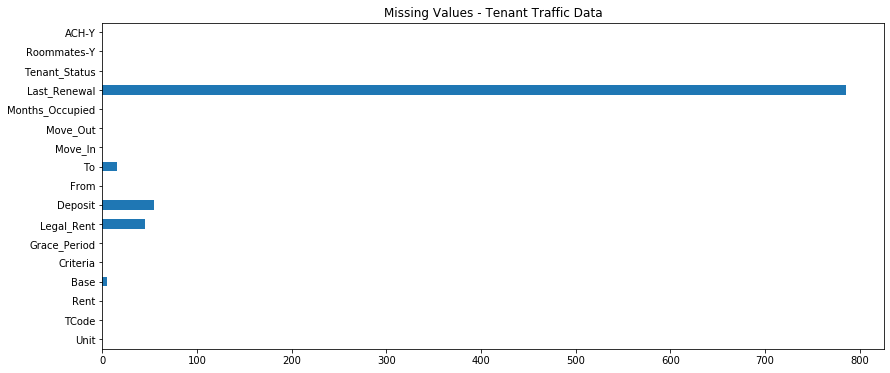

In [11]:
#Creating a Bar chart for the missing values
plt.figure(figsize = (14, 6))
df_past.isnull().sum().plot(kind='barh');
plt.title('Missing Values - Tenant Traffic Data')

__Missing Value Intrepretation__

The above graph of missing value shows that the Last Renewal Date is empty. This is reasonable as these tenants have already moved out.

In [12]:
#checking the datatype of the imported data
df_past.dtypes

Unit                object
TCode               object
Rent                object
Base               float64
Criteria            object
Grace_Period       float64
Legal_Rent          object
Deposit             object
From                object
To                  object
Move_In             object
Move_Out            object
Months_Occupied      int64
Last_Renewal        object
Tenant_Status       object
Roommates-Y         object
ACH-Y               object
dtype: object

In [13]:
combined_df['TCode'].isnull().sum()

0

In [14]:
# Correcting the Data types of Date Fields.
columns=['From', 'To', 'Move_In', 'Move_Out']
for i in columns:
    df_past[i]=pd.to_datetime(df_past[i])
    combined_df[i]=pd.to_datetime(df_past[i])

In [15]:
# Correcting the Data types from string to float in combined_df
columns=['Rent', 'Legal_Rent']
for i in columns:
    combined_df[i]=combined_df[i].str.replace(',', '').astype(float)
    df_past[i]=df_past[i].str.replace(',', '').astype(float)

In [16]:
combined_df.isnull().sum().sum()

10677

In [17]:
combined_df.fillna(0, inplace=True)

__Special Note:__

There are few columns have 'Null' values in the Dataset. For example we have 'Rent' and 'Legal Rent' columns have no value. This is not a missing data. Many tenants are get assistance from the Government or Charity Agencies. So it is Normal to have Zeros in the Rent columns. Hence we will be filling '0' with all the empty fields.

In [18]:
combined_df["Tenant_Status"].value_counts()

Current    2031
Past       1008
Name: Tenant_Status, dtype: int64

In [19]:
#Mapping if the tenants has Churned (Past)  to binary '1', '0'
combined_df['Tenant_Status'] = df_past['Tenant_Status'].map({'Past':1, 'Current':0})

In [20]:
#data cleaning and formating
combined_df['Deposit'] = combined_df['Deposit'].str.replace('(', '-')

In [21]:
#data cleaning and formating
combined_df['Deposit'] = combined_df['Deposit'].str.replace(')', '')

In [22]:
combined_df['Deposit'] = combined_df['Deposit'].str.replace(',', '').astype(float)

In [23]:
df_past['Deposit'] = df_past['Deposit'].str.replace('(', '-')

In [24]:
df_past['Deposit'] = df_past['Deposit'].str.replace(')', '')

In [25]:
df_past['Deposit'] = df_past['Deposit'].str.replace(',', '').astype(float)

In [26]:
# removing white spaces in the object type fields
df_past = df_past.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

In [27]:
#Mapping the ACH tenants (string) to binary '1', '0'
df_past['ACH-Y'] = df_past['ACH-Y'].map({'Y': 1, 'N': 0})

In [28]:
#Mapping if the tenants has roomates (string) to binary '1', '0'
df_past['Roommates-Y'] = df_past['Roommates-Y'].map({'Y':1, 'N':0})

In [29]:
#Mapping the ACH tenants (string) to binary '1', '0'
combined_df['ACH-Y'] = combined_df['ACH-Y'].map({'Y': 1, 'N': 0})

In [30]:
#Mapping if the tenants has roomates (string) to binary '1', '0'
combined_df['Roommates-Y'] = combined_df['Roommates-Y'].map({'Y':1, 'N':0})

__Combined Dataframe data__

In [31]:
combined_df['Months_Occupied'].describe()

count    3039.000000
mean       33.274761
std        17.335264
min         1.000000
25%        18.000000
50%        33.000000
75%        49.000000
max        63.000000
Name: Months_Occupied, dtype: float64

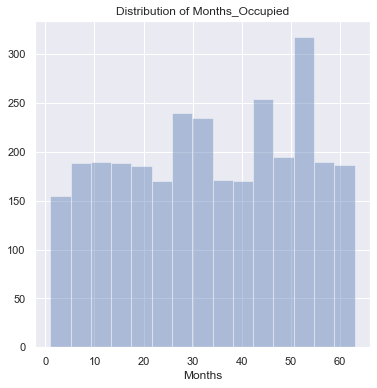

In [32]:
# Plot to viewing the distribution of Months Occupied
sns.set(rc={'figure.figsize':(6, 6)})
sns.distplot(combined_df['Months_Occupied'],
             kde= False,
             axlabel='Months'
            
            ).set_title('Distribution of Months_Occupied');

__Observation__:
I noticed that a portion of tenants were having Zero amounts against rent. This is due to thefact that these tenants are getting assistance from the New York city agencies or other Charity Organizations. For the purpose of the modeling I have decided to keep these records in the dataset.

The above Histogram also shows a variation in the tenant rents. This is due to the rentable items (Parking, Storage, etc ).

__Plotting the distribution of Legal Rent__

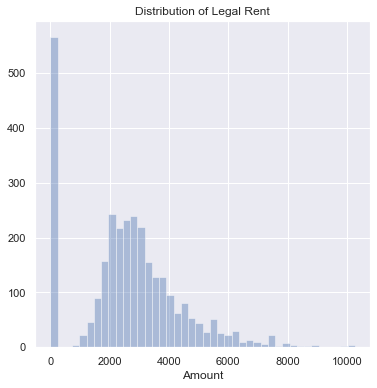

In [33]:
#Plot for seeing the Ditribution of Legal Rent.
sns.set(rc={'figure.figsize':(6, 6)})
sns.distplot(combined_df['Legal_Rent'],
             kde= False,
             axlabel='Amount'
            
            ).set_title('Distribution of Legal Rent');

__Observation__:
I noticed that a portion of tenants were having Zero amounts against rent. This is due to thefact that these tenants are getting assistance from the New York city agencies or other Charity Organizations. For the purpose of the modeling I have decided to keep these records in the dataset.

The above Histogram also shows a variation in the tenant rents. This is due to the rentable items (Parking, Storage, etc ).

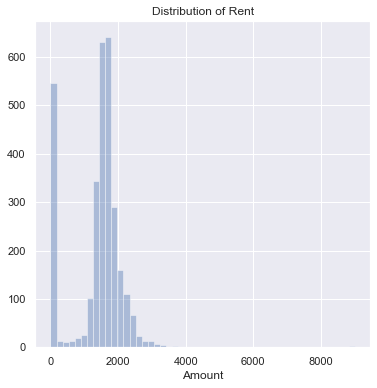

In [34]:
#Plot for seeing the Ditribution of Rent.
sns.set(rc={'figure.figsize':(6, 6)})
sns.distplot(combined_df['Rent'],
             kde= False,
             axlabel='Amount'
            
            ).set_title('Distribution of Rent');

__Observation__:
I noticed that a portion of tenants were having Zero amounts against rent. This is due to thefact that these tenants are getting assistance from the New York city agencies or other Charity Organizations. For the purpose of the modeling I have decided to keep these records in the dataset.

The above Histogram also shows a variation in the tenant rents. This is due to the rentable items (Parking, Storage, etc ).

__Understanding Daywise Moveout Traffic__

__Daywise Move out traffic__

In [35]:
df_past['Moveout_day'] = df_past['Move_Out'].dt.dayofweek
df_past['Moveout_day'].unique()

array([5, 1, 4, 2, 3, 0, 6])

In [36]:
# assigning key value to the weekdays from Monday thru Friday using .map method.
df_past['weekday'] = df_past['Moveout_day'].map({1.: 'Monday', 
                               2.: 'Tuesday',
                               3.: 'Wednesday',
                               4.: 'Thursday',
                               5.: 'Friday',
                               6.: 'Saturday',
                               0.: 'Sunday'
                               })
df_past['weekday'].unique()

array(['Friday', 'Monday', 'Thursday', 'Tuesday', 'Wednesday', 'Sunday',
       'Saturday'], dtype=object)

In [37]:
df_past['weekday'].value_counts()

Sunday       189
Monday       177
Thursday     175
Tuesday      171
Wednesday    153
Friday        98
Saturday      45
Name: weekday, dtype: int64

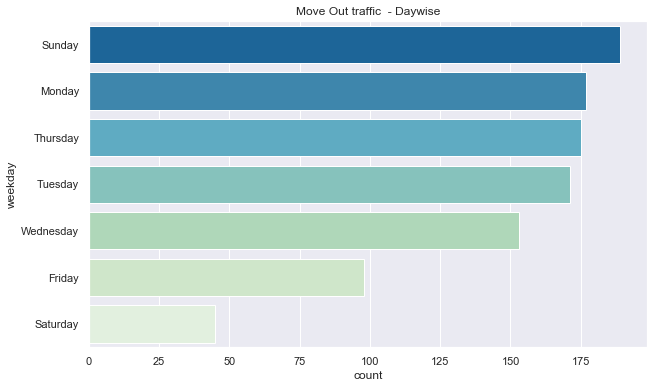

In [38]:
#Move Out traffic - Day wise
plt.figure(figsize=(10,6))
sns.set_style('darkgrid')
plt.title('Move Out traffic  - Daywise')
sns.countplot(data=df_past,
              y='weekday', 
              order = df_past['weekday'].value_counts().index,
              palette="GnBu_r");

__Daywise Moveout Traffic Graph Interpretation__

The above graph of Daywise Moveout Traffic Graph shows that most of the traffic happens mostly during Sunday & Mondays.

__Monthwise Move out traffic__

In [39]:
df_past['Moveout_month'] = df_past['Move_Out'].dt.month
df_past['Moveout_month'].unique()

array([12,  3,  5,  8, 11, 10,  1,  4,  7,  2,  6,  9])

In [40]:
# assigning key value to the weekdays from Monday thru Friday using .map method.
df_past['year_month'] = df_past['Moveout_month'].map({1.: 'Jan', 
                               2.: 'Feb',
                               3.: 'Mar',
                               4.: 'Apr',
                               5.: 'May',
                               6.: 'Jun',
                               7.: 'Jul',
                               8.: 'Aug',
                               9.: 'Sep',
                               10.: 'Oct',
                               11.: 'Nov',
                               12.: 'Dec'

                               })
df_past['year_month'].unique()

array(['Dec', 'Mar', 'May', 'Aug', 'Nov', 'Oct', 'Jan', 'Apr', 'Jul',
       'Feb', 'Jun', 'Sep'], dtype=object)

In [41]:
month_order = ['Jan', 'Feb','Mar','Apr', 'May', 'Jun', 'Jul', 'Aug','Sep', 'Oct', 'Nov', 'Dec']

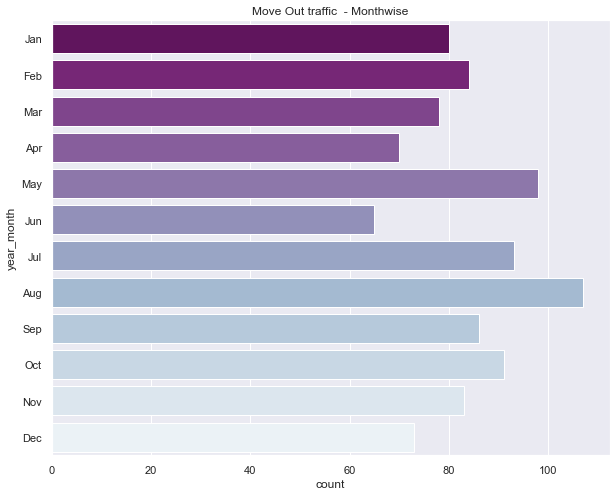

In [42]:
#Move Out traffic - Month wise
plt.figure(figsize=(10,8))
sns.set_style('darkgrid')
plt.title('Move Out traffic  - Monthwise')
sns.countplot(data=df_past,
              y='year_month', 
              order = month_order,
              #order = df_past['year_month'].value_counts().index,
              palette="BuPu_r");

__Monthwise Moveout Traffic Graph Intrepretation__

The above graph of Monthwise Moveout Traffic Graph shows that most of the traffic happens during   Summer months (May, Jul, Aug, Oct). I have also noticed noticed that the traffic is more just after the beginning of School Holidays and picks up just before School start month.

In [43]:
filtered_df = df_past[df_past['Move_Out'].notnull()]

In [44]:
filtered_df.dropna(inplace=True)

__Preprocessing__

In [45]:
# Train test split
X = filtered_df[['Rent', 'Legal_Rent', 'Roommates-Y', 'Deposit']]
y = filtered_df['Months_Occupied']

In [46]:
filtered_df.head()

,Unit,TCode,Rent,Base,Criteria,Grace_Period,Legal_Rent,Deposit,From,To,...,Move_Out,Months_Occupied,Last_Renewal,Tenant_Status,Roommates-Y,ACH-Y,Moveout_day,weekday,Moveout_month,year_month
12,1-2F,t0008667,1815.0,5.0,% Monthly Rent,5.0,3893.10,2549.00,2018-05-01,2020-04-30,...,2018-05-01,47,04/09/18,Past,1,0,1,Monday,5,May
21,1-4C,t0008216,1889.0,5.0,% Monthly Rent,5.0,5381.15,0.00,2018-04-01,2020-03-31,...,2018-08-31,48,03/23/18,Past,1,0,4,Thursday,8,Aug
31,1-5D,t0009998,1499.0,50.0,Flat Amount,5.0,2100.07,2069.03,2018-11-01,2019-10-31,...,2019-10-05,41,10/08/18,Past,1,0,5,Friday,10,Oct
47,1-L1,t0008198,1575.0,5.0,% Owed-month,5.0,2560.93,0.00,2018-05-01,2019-04-30,...,2019-04-30,47,04/16/18,Past,1,0,1,Monday,4,Apr
74,4-1R,t0005773,960.0,0.0,% Owed-month,0.0,2842.13,1454.00,2016-02-01,2017-01-31,...,2016-03-31,63,01/14/16,Past,0,0,3,Wednesday,3,Mar


# Modeling 

__Baseline Model__

In [47]:
#just making sure there is no Nan values in the data we will use in the 
#following models
combined_df.fillna(0, inplace=True)

In [48]:
combined_df['Tenant_Status'].value_counts(normalize = True)

0.0    0.668312
1.0    0.331688
Name: Tenant_Status, dtype: float64

__Preprocessing & Classification Modeling__

In [49]:
X_cols = ['Rent', 'Base',
         'Grace_Period', 'Legal_Rent', 'Deposit', 
         'Roommates-Y', 'ACH-Y','Months_Occupied']

X = combined_df[X_cols]
y = combined_df['Tenant_Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = RANDOM_STATE)

### Logistic Regression Model

In [50]:
pipe_log = Pipeline([('sc', StandardScaler()),
                ('log', LogisticRegression(solver = 'liblinear'))
])
params_log = {'sc__with_mean': [True, False], 
                 'sc__with_std': [True, False],
                 'log__C': [1e9, 0.0001, 10]}
            
gs_log = GridSearchCV(pipe_log, 
                     params_log,
                 cv=5, 
)

log_model = gs_log.fit(X_train, y_train)

print(f'Score on training set: {log_model.score(X_train, y_train)}')
print(f'Score on testing set: {log_model.score(X_test, y_test)}')
print(f'Cross Val Score: {cross_val_score(log_model.best_estimator_, X, y, cv=5).mean()}')

Score on training set: 0.9245283018867925
Score on testing set: 0.9157894736842105
Cross Val Score: 0.91967825211213


__Logistic Regression Model Score Intrepretation__

**The above Logistics Regression Model has accuracy of 0.99 for my training set and has accuracy 0.99 for my testing set. This model out performs my baseline model score of 0.67**

### KNN Model

In [51]:
pipe_kn1 = Pipeline([('sc', StandardScaler()),
    ('kn', KNeighborsClassifier())
])
params_kn1 = {'sc__with_mean': [True, False], 
                 'sc__with_std': [True, False],
                 'kn__p': [1, 2], 
                 'kn__weights': ['uniform', 'distance'],
                 'kn__n_neighbors': [3, 5, 10]}
                 
gs_kn1 = GridSearchCV(pipe_kn1, 
                     params_kn1,
                 cv=5, 
)

kn1_model = gs_kn1.fit(X_train, y_train)
print(f'Score on training set: {kn1_model.score(X_train, y_train)}')
print(f'Score on testing set: {kn1_model.score(X_test, y_test)}')
print(f'Cross Val Score: {cross_val_score(kn1_model.best_estimator_, X, y, cv=5).mean()}')

Score on training set: 1.0
Score on testing set: 0.9394736842105263
Cross Val Score: 0.9496233384759976


__KNN Model Score Intrepretation__

**The above KNN Model has accuracy of 0.99 for my training set and has accuracy 0.95 for my testing set. This model performs same as my baseline model score of 0.67**

### Decision Tree Model

In [52]:
pipe_dt1 = Pipeline([('sc', StandardScaler()),
    ('dt',DecisionTreeClassifier())
])
params_dt1 = {'sc__with_mean': [True, False], 
                 'sc__with_std': [True, False],
                 'dt__max_depth':[3,5,7],
                 'dt__min_samples_split':[10,15,20],
                 'dt__min_samples_leaf':[5,7,9]
                   }
                 
gs_dt1 = GridSearchCV(pipe_dt1, 
                     params_dt1,
                 cv=5, 
)



dt1_model = gs_dt1.fit(X_train, y_train)
# Evaluate model.
print(f'Score on training set: {dt1_model.score(X_train, y_train)}')
print(f'Score on testing set: {dt1_model.score(X_test, y_test)}')
print(f'Cross Val Score: {cross_val_score(dt1_model.best_estimator_, X, y, cv=5).mean()}')

Score on training set: 0.9627029398859148
Score on testing set: 0.9618421052631579
Cross Val Score: 0.952921488270184


__Decision Tree Score Intrepretation__

**The above Decsion tree model has accuracy of 0.99 for my training set and has accuracy 0.99 for my testing set. This model out performs my baseline model score of 0.67**

### Bagged Tree Model

In [53]:
pipe_bag1 = Pipeline([('sc', StandardScaler()),
    ('bag',BaggingClassifier())
])
params_bag1 = {'sc__with_mean': [True, False], 
              'sc__with_std': [True, False],
              'bag__n_estimators': [10, 20, 30],
              'bag__max_samples': [1, 2, 3],
              'bag__bootstrap': [True],
                   }
                 
gs_bag1 = GridSearchCV(pipe_bag1, 
                     params_bag1,
                 cv=5, 
)



bag1_model = gs_bag1.fit(X_train, y_train)
# Evaluate model.
print(f'Score on training set: {bag1_model.score(X_train, y_train)}')
print(f'Score on testing set: {bag1_model.score(X_test, y_test)}')
print(f'Cross Val Score: {cross_val_score(bag1_model.best_estimator_, X, y, cv=5).mean()}')

Score on training set: 0.6687143483984204
Score on testing set: 0.6671052631578948
Cross Val Score: 0.7394034166182941


__Random Forest Score Intrepretation__

**The above Random Forest model has accuracy of 0.67 for my training set and has accuracy 0.66 for my testing set. This model performs same as my baseline model score of 0.67**

### Random Forest

In [54]:
pipe_rf1 = Pipeline([('sc', StandardScaler()),
        ('rf',RandomForestClassifier())
])
params_rf1= {'sc__with_mean': [True, False], 
                 'sc__with_std': [True, False],
                  'rf__n_estimators': [100, 150, 200],
            'rf__max_depth': [None, 1, 2, 3, 4, 5], }
                 
gs_rf1 = GridSearchCV(pipe_rf1, 
                     params_rf1,
                 cv=5, )




rf1_model = gs_rf1.fit(X_train, y_train)
# Evaluate model.
print(f'Score on training set: {rf1_model.score(X_train, y_train)}')
print(f'Score on testing set: {rf1_model.score(X_test, y_test)}')

print(f'Cross Val Score: {cross_val_score(rf1_model.best_estimator_, X, y, cv=5).mean()}')

Score on training set: 1.0
Score on testing set: 0.9552631578947368
Cross Val Score: 0.9558798468932658


__Random Forest Score Intrepretation__

**The above Random Forest model has accuracy of 0.99 for my training set and has accuracy 0.99 for my testing set. This model out performs my baseline model score of 0.67**

In [55]:
preds = rf1_model.predict(X_test)

### Extra trees model

In [56]:
pipe_et1 = Pipeline([('sc', StandardScaler()),
        ('et',ExtraTreesClassifier())
])
params_et1= {'sc__with_mean': [True, False], 
                 'sc__with_std': [True, False],
                  'et__n_estimators': [100, 150, 200],
            'et__max_depth': [None, 1, 2, 3, 4, 5], }
                 
gs_et1 = GridSearchCV(pipe_et1,
                        param_grid=params_et1,
                        cv=5,
                        scoring='accuracy',
                        n_jobs=-2)



et1_model = gs_et1.fit(X_train, y_train)
# Evaluate model.
print(f'Score on training set: {et1_model.score(X_train, y_train)}')
print(f'Score on testing set: {et1_model.score(X_test, y_test)}')
print(f'Cross Val Score: {cross_val_score(et1_model.best_estimator_, X, y, cv=5).mean()}')

Score on training set: 1.0
Score on testing set: 0.9565789473684211
Cross Val Score: 0.9525898259467336


In [57]:
pipe = Pipeline(steps=[('extra_trees', ExtraTreesClassifier())])

params = {'extra_trees__n_estimators': [300, 400, 500, 600]}
gs_extra_trees = GridSearchCV(pipe,
                              param_grid=params,
                              cv=5,
                              scoring='accuracy',
                              n_jobs=-2)
gs_extra_trees.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('extra_trees',
                                        ExtraTreesClassifier(bootstrap=False,
                                                             class_weight=None,
                                                             criterion='gini',
                                                             max_depth=None,
                                                             max_features='auto',
                                                             max_leaf_nodes=None,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=1,
                                                             min_samples_split=2,
                                 

__Extra trees Score Intrepretation__

**The above Extra Trees model has accuracy of 1.0 for my training set and has accuracy 0.96 for my testing set. This model out performs my baseline model score of 0.67**

### Neural Network Model

In [58]:
X_cols = ['Rent', 'Base',
         'Grace_Period', 'Legal_Rent', 'Deposit', 
         'Roommates-Y', 'ACH-Y','Months_Occupied']

X = combined_df[X_cols]
y = combined_df['Tenant_Status'].astype('int')

X_train, X_test, y_train, y_test = train_test_split(X, y)
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_nn = ss.transform(X_test)

In [59]:
1 - y.mean()

0.6683119447186574

In [60]:
n_input = X_train_sc.shape[1]

In [61]:
n_input

8

In [62]:
model = Sequential()

model.add(Dense(18, input_dim=n_input, activation='relu')) #input layer
model.add(Dense(18, input_dim=n_input, activation='relu')) #hidden layer
model.add(Dense(1, activation='sigmoid')) #output layer

In [63]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [64]:
history = model.fit(
    X_train_sc,
    y_train,
    validation_data=(X_test_nn, y_test),
    epochs=100,
    batch_size=None,
    verbose=2
)

Train on 2279 samples, validate on 760 samples
Epoch 1/100
 - 0s - loss: 0.5736 - acc: 0.7016 - val_loss: 0.4430 - val_acc: 0.8079
Epoch 2/100
 - 0s - loss: 0.3457 - acc: 0.8798 - val_loss: 0.2836 - val_acc: 0.9079
Epoch 3/100
 - 0s - loss: 0.2224 - acc: 0.9315 - val_loss: 0.2133 - val_acc: 0.9250
Epoch 4/100
 - 0s - loss: 0.1777 - acc: 0.9377 - val_loss: 0.1876 - val_acc: 0.9250
Epoch 5/100
 - 0s - loss: 0.1604 - acc: 0.9408 - val_loss: 0.1792 - val_acc: 0.9303
Epoch 6/100
 - 0s - loss: 0.1506 - acc: 0.9421 - val_loss: 0.1726 - val_acc: 0.9289
Epoch 7/100
 - 0s - loss: 0.1455 - acc: 0.9438 - val_loss: 0.1690 - val_acc: 0.9329
Epoch 8/100
 - 0s - loss: 0.1405 - acc: 0.9443 - val_loss: 0.1648 - val_acc: 0.9342
Epoch 9/100
 - 0s - loss: 0.1366 - acc: 0.9456 - val_loss: 0.1617 - val_acc: 0.9355
Epoch 10/100
 - 0s - loss: 0.1327 - acc: 0.9460 - val_loss: 0.1600 - val_acc: 0.9368
Epoch 11/100
 - 0s - loss: 0.1304 - acc: 0.9460 - val_loss: 0.1583 - val_acc: 0.9382
Epoch 12/100
 - 0s - loss: 

Epoch 97/100
 - 0s - loss: 0.0864 - acc: 0.9649 - val_loss: 0.1484 - val_acc: 0.9447
Epoch 98/100
 - 0s - loss: 0.0858 - acc: 0.9649 - val_loss: 0.1493 - val_acc: 0.9408
Epoch 99/100
 - 0s - loss: 0.0877 - acc: 0.9662 - val_loss: 0.1501 - val_acc: 0.9434
Epoch 100/100
 - 0s - loss: 0.0856 - acc: 0.9662 - val_loss: 0.1484 - val_acc: 0.9434


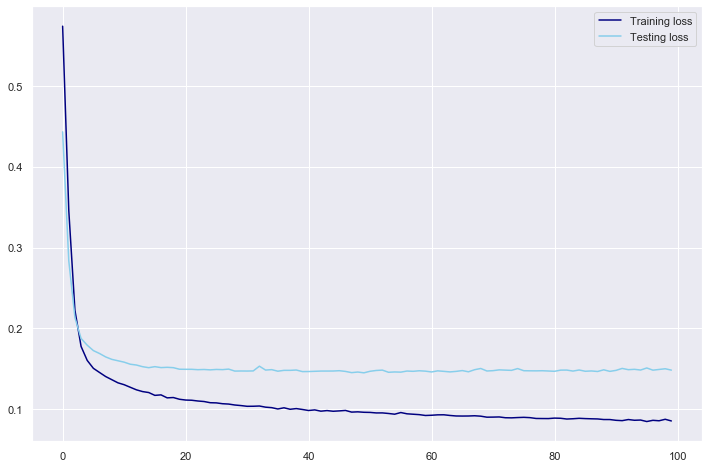

In [65]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']
plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.legend();

In [66]:
history.history['acc'][-1], history.history['val_acc'][-1]

(0.9662132, 0.9434210658073425)

# Model Selection and Evaluation 

**Model performance at a glance :**

**Baseline score = 0.67**

| Sl. No     | Classifier | Train Score | Test Score |Cross Val Score |
|------------|------------|-------------|------------|----------------|
|  1         | LogisticReg| 0.92        | 0.92       | 0.92           |
|  2         | KNN Model  | 0.96        | 0.95       | 0.95           |
|  3         | Descn Tree | 0.96        | 0.95       | 0.95           |
|  4         | Bgd. Tree  | 0.70        | 0.68       |
|  5         | Rndm Frst  | 1.00        | 0.95       |
|  6         | Extra Trees| 1.00        | 0.95       |
|  5         | Neurl Ntwrk| 0.96        | 0.95       |

Extra trees model produced 0.95 accuracy score - better than other machine models.

In [67]:
def c_confusion_matrix(y_true, y_pred):
    # handling data
    cm = confusion_matrix(y_true, y_pred)
    labels = y_true.unique()
    labels.sort()
    
    # plotting
    sns.set(font_scale=1.2)
    plt.figure(figsize=(10,4))
    
   
    
    sns.heatmap(cm, annot=True, fmt='g', cmap="BuPu",xticklabels=labels, yticklabels=labels)
    plt.title("Confusion Matrix")
    plt.xlabel('Predicted Churned Tenants')
    plt.ylabel('True Churned Tenants')
    
    b, t = plt.ylim()
    b += 0.8
    t -= 0.8
    plt.ylim(b, t)
    

## Confusion Matrix

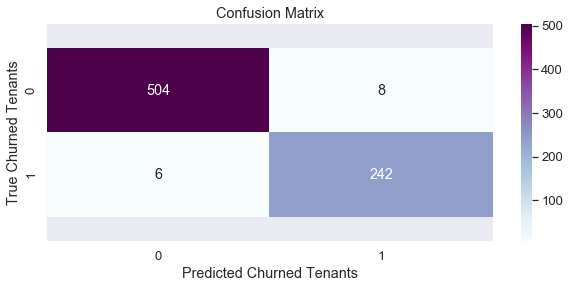

In [68]:
preds = kn1_model.predict(X_test)
c_confusion_matrix(y_test, preds)

 - The "1" which is 'Churned Tenant' category is predicted correctly => True positive score = 494
 - The "1" which is 'Churned Tenant' category is predicted incorrectly => False positive = 13
 - The "0" which is 'Current Tenant' category is predicted correctly => True negative = 241
 - The "12" which is 'Current Tenant' is predicted incorrectly => False positive = 4

## ROC AUC Curve

Receiver Operating Characteristic (ROC) Curve & Area under the ROC curve

I am using Receiver Operating Characteristic curve to visualize the overlap between my positive class and negative class by moving our classification threshold from 0 to 1.

I am using the area under the ROC curve (abbreviated ROC AUC or AUC ROC) to quantify the gap between our distributions.

In [69]:
pred_proba = [i[1] for i in et1_model.predict_proba(X_test)]
pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})

In [70]:
from sklearn.metrics import roc_auc_score
roc_auc_score(pred_df['true_values'], pred_df['pred_probs'])

0.9996298513104839

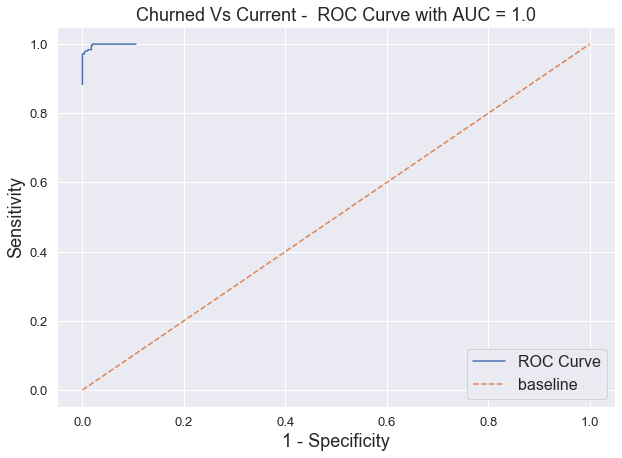

In [71]:
# Create figure.
plt.figure(figsize = (10,7))
# Create threshold values.
thresholds = np.linspace(0, 1, 200)
# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')
# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')
# Label axes.
plt.title(f'Churned Vs Current -  ROC Curve with AUC = {round(roc_auc_score(pred_df["true_values"], pred_df["pred_probs"]),3)}', fontsize=18)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)
# Create legend.
plt.legend(fontsize=16);

__Interpreting ROC AUC__

We have an ROC AUC of 0.90 which is less than we would have liked( Which is close to 1) .In otherwords in our Extra trees model model our Tenant churn (positive) and Current Tenants (negative) populations are 90% perfectly separated. Looking at our model we can conclude that our model has scope to improve and needs to get as close as to 1.

## Feature Importance

In [72]:
# Best Estimator for GridSearch
gs_extra_trees.best_estimator_

Pipeline(memory=None,
         steps=[('extra_trees',
                 ExtraTreesClassifier(bootstrap=False, class_weight=None,
                                      criterion='gini', max_depth=None,
                                      max_features='auto', max_leaf_nodes=None,
                                      min_impurity_decrease=0.0,
                                      min_impurity_split=None,
                                      min_samples_leaf=1, min_samples_split=2,
                                      min_weight_fraction_leaf=0.0,
                                      n_estimators=400, n_jobs=None,
                                      oob_score=False, random_state=None,
                                      verbose=0, warm_start=False))],
         verbose=False)

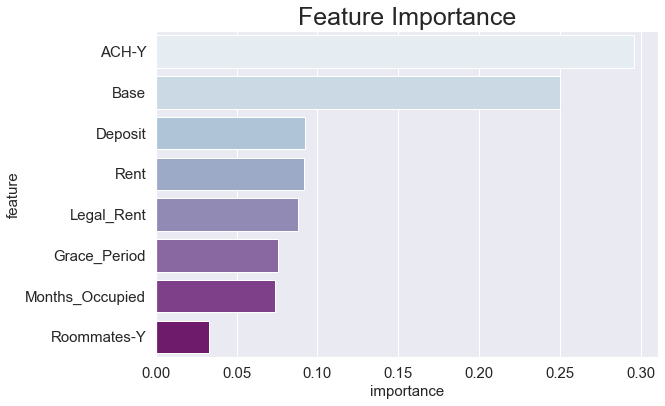

In [73]:
# getting the feature importances crom the model
feats =gs_extra_trees.best_estimator_.steps[0][1].feature_importances_
# getting keys of the test set
keys = X_test.keys()
# zipping the keys and feature importances
feat_import = pd.DataFrame(list(zip(keys, feats)),
                           columns=['feature', 'importance'])
# sorting the dataframe by importance
feat_import = feat_import.sort_values(by='importance', ascending=False)

# plotting importance
plt.figure(figsize=(9, 6))
plt.title('Feature Importance', fontsize=25)
sns.set_style("darkgrid")
sns.barplot(data=feat_import,
            x='importance',
            y='feature',
            orient='h',
            palette="BuPu")
plt.xlabel('importance', fontsize=15)
plt.ylabel('feature', fontsize=15)
plt.tick_params(labelsize=15)

__Feature Importance Intrepretation__

The above graph of Feature importance Months Occupied as the most important feature. The next important feature is ACH-Y i.e, if a tenant signed up for Automatic electronic payments. 

 - We can infer from this findings that longer a tenant stays in a Unit he is less likely to churn / move-out. 
Armed with this information the landlords can give incentives to the tenants who are signing up for longterm lease contracts.

 - Another interesting findings is that the tenants who signed up for electronic payments tend to stay longer. 


## Model Coeficients

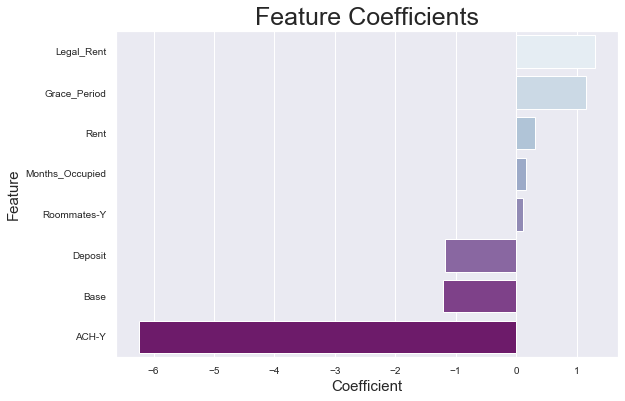

In [74]:
# getting the feature coefficiants crom the Logistic Regression model
coefs = gs_log.best_estimator_.steps[1][1].coef_
# getting keys of the test set
keys = X_test.keys()
# zipping the keys and feature importances
feat_coef = pd.DataFrame(list(zip(keys, coefs[0])),
                         columns=['feature', 'coefficient'])
# sorting the dataframe by coefficients
feat_coef = feat_coef.sort_values(by='coefficient', ascending=False)

# plotting coefficients
plt.figure(figsize=(9, 6))
plt.title('Feature Coefficients', fontsize=25)
sns.set_style("darkgrid")
sns.barplot(data=feat_coef,
            x='coefficient',
            y='feature',
            orient='h',
            palette="BuPu")
plt.xlabel('Coefficient', fontsize=15)
plt.ylabel('Feature', fontsize=15)
plt.tick_params(labelsize=10)

__Feature Coefficients Intrepretation__

The above graph of Feature coefficient shows positive correlation with Legal Rent and Grace Period (Days that a tenant can pay late). It shows a negative correlation with Tenants in automatic rent debit and Base Fee (The % of late fee collected on the rent) 

 - We can infer from this findings that Low rent paying tenant tends to stay longer in a Unit  that is he is less likely to churn / move-out. 
 
 - Another interesting findings is that the tenants who signed up for electronic payments tend to stay longer. 


## Conclusion


With help of available data from Voyager a Property Management System I was able to predict Churned and Non Churned tenant with great accuracy. During the modeling process we found that few features have high (Positive and Negative) coefficients related for Tenant being Churned. __ACH-Y (Tenant Signed up for Auto debit of their  Rents)__ was a great indicator in our models. One of the __unusual findings__ is that the __Deposit__ and __Legal Rent__ didn't have much impact.

One of the observation I found in our best performing model the Extra Tree Model is that the Train scores always performed much better than the and Test and Cross val score on the original dataset. Even after trying with different Random State I couldn't improve the Cross Val scores on the Original data set. This needs further investigation. 

While the model performed great we still have scope to improve by introducing the time elements to help the Property Managers taking informed decisions.

### Recommendations and furthur plans

With the Machine Learning models performing well in predicting the Tenant classification, we would like to create a Generalized Linear Model to predict possibility of a Tenant churning with in a speficif time perdiod (say in the next 6 months). 
I have given sample approach in my recommendations here with a GLM modelmusing a Gamma function. 

I also would like to Engineer more features that can be used on a GLM model. 

__Future plans for predicting Tenant Churn using GLM with Gamma function__

In [75]:
# adding y-intercept

X = sm.add_constant(X)

glm_gamma = sm.GLM(y,
                  X,
                  family = sm.families.Gamma(link = sm.families.links.log))

# Fit
fitted_glm_gamma = glm_gamma.fit()


# Generating summary of model.
fitted_glm_gamma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:          Tenant_Status   No. Observations:                 3039
Model:                            GLM   Df Residuals:                     3030
Model Family:                   Gamma   Df Model:                            8
Link Function:                    log   Scale:                         0.81990
Method:                          IRLS   Log-Likelihood:                    inf
Date:                Wed, 11 Mar 2020   Deviance:                   1.4266e+05
Time:                        14:32:38   Pearson chi2:                 2.48e+03
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.7419      0.022    -33.297      0.000      -0.786      -0.698
Rent             4.344e-05   7.79e-07     55.799      0.000    4.19e-05     4.5e-05
Base               -0.0030   3.65e-05    -81.701      0.000      -0.003      -0.003
Grace_Period        0.0418      0.000    108.234      0.000       0.041       0.043
Legal_Rent       1.717e-05   2.76e-07     62.254      0.000    1.66e-05    1.77e-05
Deposit         -2.317e-05   3.24e-07    -71.514      0.000   -2.38e-05   -2.25e-05
Roommates-Y        -0.0003      0.001     -0.314      0.754      -0.002       0.001
ACH-Y             -39.6423      0.022  -1780.736      0.000     -39.686     -39.599
Months_Occupied    -0.0002   2.22e-05     -9.819      0.000      -0.000      -0.000
===================================================================================
"""

In [76]:
# checking if model converged
fitted_glm_gamma.converged

False

### Production Pipeline

Since our model prototype has been established that surpassed the desired performance thresholds, it is ready for the production line. 

These are the thoughts for a production line can be thought of as the following:

 - Data injection from a data warehouse (In this case from Voyager - Business Application)

 - Model training update 

 - Test and report the most recent model performance to the stakeholders

 - Loading the flagged users (potential churners) back to the database

While  what should be done with the users that are churn-tagged remains an open question to product owners. A scientific approach is to run A/B tests on various segments of churners, optimize for a product, and experience change that increases user retention.

In [77]:
preds = rf1_model.predict(X_test)

In [78]:
tc = combined_df.loc[X_test.index,'TCode']

In [79]:
new_df = pd.DataFrame({'Tcodes': tc, 'preds': preds})
new_df.head()

,Tcodes,preds
3778,t0007138,1.0
4934,t0015577,0.0
4845,t0015363,0.0
4859,t0015390,1.0
442,t0010438,0.0


In [80]:
#writing ouput to csv
new_df.to_csv("../output/Finalsubmission_kr", index = False)

### External Research

![title](../assets/Property_Stats.png)  

__Sources :__
 - Investopedia, “Property Manager.”
 - Property Manager Insider, “Best Undergraduate Degrees for Property Managers.”
 - Buildium, “2018 State of the Property Management Industry Report.”
 - IBISWorld, “Property Management in the U.S. – Market Research Report.”
 - Statista, “Rental Vacancy Rates in the United States 2000 to 2018 by Region.”

In [81]:
pickle.dump(gs_et1, open('../output/model.pkl', 'wb'))